In [1]:
import numpy as np
from matplotlib import pyplot as plt
from photon_canon.contrib import calculate_mus
from tqdm import tqdm
from tqdm.contrib import itertools
import scipy.optimize as opt
from functools import partial
import cv2

from hsdfmpm.hsdfm import HyperspectralImage, MergedHyperspectralImage
from hsdfmpm.hsdfm.utils import find_cycles
from hsdfmpm.hsdfm.contrib import generate_phantom_profiles
from photon_canon.contrib.food_coloring import make_mix
from photon_canon.lut import LUT

# Modelling parameters

In [2]:
smoothing_fn = partial(cv2.GaussianBlur, ksize=(3, 3), sigmaX=2)
lut = LUT(dimensions=['mu_s', 'mu_a'], scale=50000, extrapolate=True, simulation_id=110, smoothing_fn=smoothing_fn)
wavelengths = np.arange(520, 610, 10, dtype=float)
ref_wavelength = 650

# Preprocessing constants
To ensure quantitative outputs, all images must be normalized before comparisons.
$$
I'_{\lambda ij} = \frac{
               \frac{I_{\lambda ij}}{\tau_\lambda} - \frac{I^{(\mathrm{bg})}_{\lambda ij}}{\tau^{(\mathrm{bg})}_\lambda}
               }{
               \frac{I^{(\mathrm{std})}_{\lambda ij}}{\tau^{(\mathrm{std})}_\lambda} - \frac{I^{(\mathrm{bg})}_{\lambda ij}}{\tau^{(\mathrm{bg})}_\lambda}
               }
$$

So a background measurement and a standard measurement are needed. Importantly, the standard may have a scalar associated with it that should be factored in prior to normalization.

In [4]:
# Dark background cube
background_cube = HyperspectralImage(image_path=r'D:\Jesse\Animal POC\PhantomStudy\standards04222025\dark\cycle1', wavelengths=wavelengths)
background_cube.normalize_integration_time()

# Average spectralon standard
standard_paths = find_cycles(r'D:\Jesse\Animal POC\PhantomStudy\standards04222025\standard_080')
standard_cube = MergedHyperspectralImage(image_paths=standard_paths, scalar=0.8, wavelengths=wavelengths)
standard_cube.normalize_integration_time()


[None, None, None]

# Study design
Before validation on the phantoms, the phantoms must be made.

## Correction-factor Standard
First, a correction factor reference must be prepared. A solution with a known scattering coefficient (using Mie theory) will be prepared and imaged under the same conditions as the phantoms. The model is then used to predict the reflectance from the known scattering coefficients. The difference between the modelled and the measured reflectance is used to calculate a correction factor:

$$
C = \frac{R_e}{R_m}
$$

This correction factor will be applied to all images prior to modelling.

In [5]:
def reduced_scatter_by_inverse_law(x, a, b):
    return a * (x / ref_wavelength) ** -b

To create scattering coefficient: 50 cm^-1.
Dissolve 58.07 uL of beads into  941.93 uL of water.


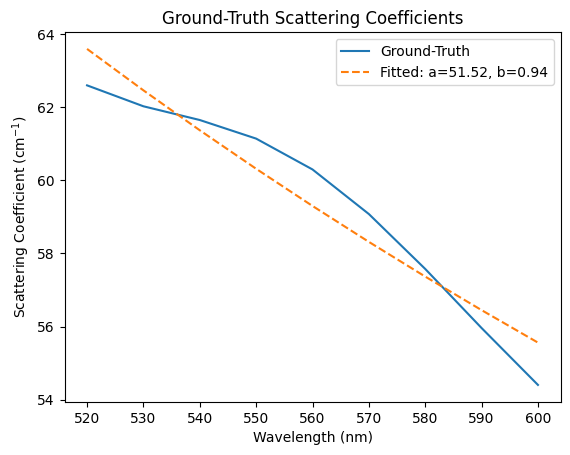

In [7]:
desired_scattering_coef = 50
g = 0.9
reduced_desired = desired_scattering_coef * (1 - g)
mie_theory_result = generate_phantom_profiles(
    wavelengths=wavelengths,
    bead_radius_um=0.746/2, sphere_type="beads",
    tot_vol_ml=1.0, per_sol_percent=2.61,
    mode='both', bead_volumes_ul=np.array([6.20]),
    red_scat_coef=np.array([reduced_desired]),
    ref_wavelength=ref_wavelength)
print(f'To create scattering coefficient: {desired_scattering_coef} cm^{-1}.')
print(f'Dissolve {mie_theory_result['volume_distribution_scatter_ul'][0]:0.2f} uL of beads into  '
     f'{mie_theory_result['volume_distribution_scatter_ul'][1]:0.2f} uL of water.')
ground_truth_mu_s = mie_theory_result['musp_profiles_cm_inv_beads'] / (1 - g)
popt, _ = opt.curve_fit(reduced_scatter_by_inverse_law, wavelengths, ground_truth_mu_s)
a_gt, b_gt = popt[0], popt[1]
fitted_mu_s = reduced_scatter_by_inverse_law(wavelengths, *popt)
plt.plot(wavelengths, ground_truth_mu_s, label='Ground-Truth')
plt.plot(wavelengths, fitted_mu_s, '--', label=f'Fitted: a={a_gt:.2f}, b={b_gt:.2f}')
plt.title('Ground-Truth Scattering Coefficients')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scattering Coefficient (cm$^{-1}$)')
plt.legend()
plt.show()

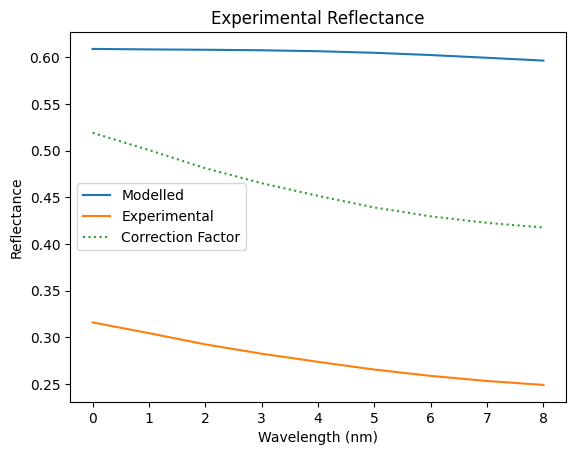

In [10]:
R_m = lut(ground_truth_mu_s, np.zeros_like(ground_truth_mu_s))
plt.plot(R_m, label='Modelled')

R_e = HyperspectralImage(image_path=r'D:\Jesse\Animal POC\PhantomStudy\standards04222025\known_scatterer\cycle1', standard=standard_cube, background=background_cube, wavelengths=wavelengths)
R_e.normalize()
plt.plot(np.nanmean(R_e, axis=(1, 2)), label='Experimental')

C = R_e / R_m[..., np.newaxis, np.newaxis]

plt.plot(np.nanmean(C, axis=(1, 2)), ':', label='Correction Factor')

plt.title('Experimental Reflectance')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

# Phantom design
Two solutions will be designed from mixtures of food coloring to have similar but distinct spectra in the wavelength range 500-720 nm. The absorption of a 1 $\mu$L / mL sample in water each solution will be measured directly and used as the reference concentration. The stocks will then be dissolved with a fixed concntration but varying amounts of each into a series of phantoms.

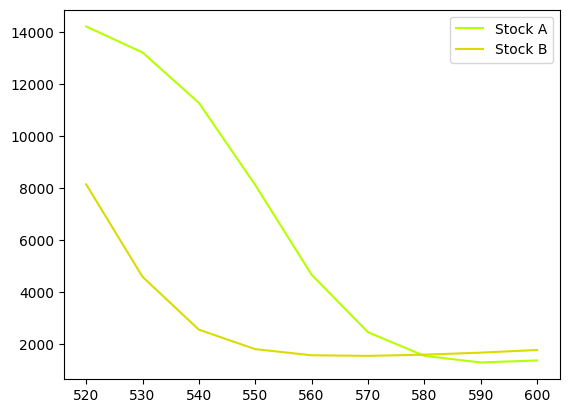

In [11]:
# Make simulated stock solutions
stock_a = make_mix(wavelengths, red=12.5, green=17.5)
stock_b = make_mix(wavelengths, yellow=60.0, blue=0.5)
plt.plot(wavelengths, stock_a, label='Stock A', color=np.array((12.5, 17.5, 0)) / 17.5)
plt.plot(wavelengths, stock_b, label='Stock B', color= np.array((30, 30, 0.5)) / 35)
plt.legend()
plt.show()

## Actual measurements
After determining the ratios for the stock solutions, actual solutions were mixed and the absoprtion of 10 $\mu$L/mL solutions was measured in a 1 cm cuvette. These measures will serve as the ground-truth for the model to fit back to.

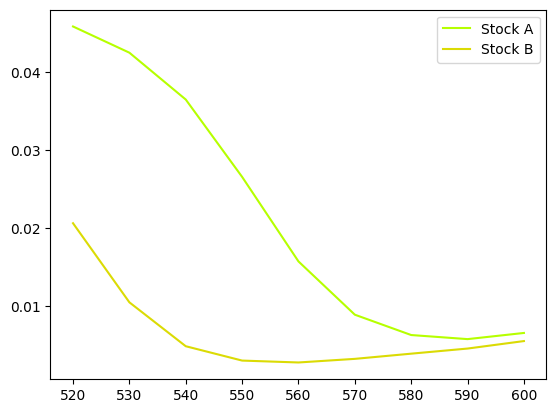

In [12]:
# Loaded actual measurements into photon_canon data
# Make simulated stock solutions
stock_a = make_mix(wavelengths, stock_a=1)
stock_b = make_mix(wavelengths, stock_b=1)
plt.plot(wavelengths, stock_a, label='Stock A', color=np.array((12.5, 17.5, 0)) / 17.5)
plt.plot(wavelengths, stock_b, label='Stock B', color= np.array((30, 30, 0.5)) / 35)
plt.legend()
plt.show()

## Phantom panel


In [82]:
def get_food_coloring_mus(wavelength, a, b, t, s):
    wl0 = 720
    conc_a = s * t
    conc_b = (1 - s) * t
    epsilons = [stock_a * conc_a, stock_b * conc_b]
    mu_s, mu_a, _ = calculate_mus(a, b, [conc_a, conc_b], epsilons, wavelength, wl0, force_feasible=False)
    return mu_s, mu_a

def model_from_food_coloring(a, b, t, s, c):
    if isinstance(a_gt, np.ndarray):
        r = np.zeros((len(wavelengths),) + a_gt.shape)
        for i, j in itertools.product(range(r.shape[1]), range(r.shape[2])):
            mu_s, mu_a = get_food_coloring_mus(wavelengths, a[i, j], b[i, j], t[i, j], s[i, j])
            r[:, i, j] = lut(mu_s / (1 - g), mu_a)
    else:
        mu_s, mu_a = get_food_coloring_mus(wavelengths, a, b, t, s)
        r = lut(mu_s / (1- g), mu_a)
    return r + c

100%|██████████| 5/5 [00:47<00:00,  9.43s/it]


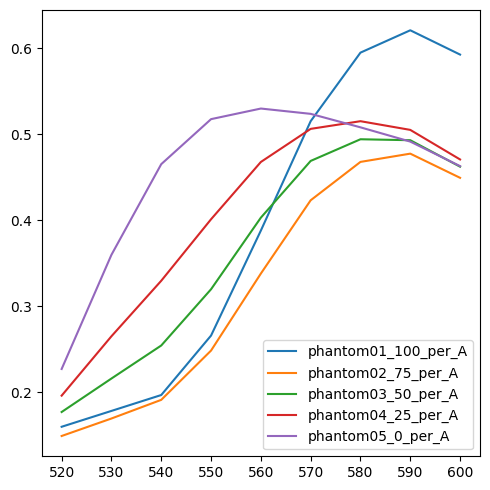

In [14]:
phantom_paths = find_cycles(r'D:\Jesse\Animal POC\PhantomStudy\phantoms04222025')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, phantom in enumerate(tqdm(phantom_paths)):
    # Load the phantom
    phantom_cube = HyperspectralImage(image_path=phantom, standard=standard_cube, background=background_cube, scalar=C, wavelengths=wavelengths)
    phantom_cube.normalize()

    ax.plot(wavelengths, np.nanmean(phantom_cube, axis=(1, 2)), label=f'{phantom.parts[-2]}')
ax.legend()
plt.tight_layout()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

 20%|██        | 1/5 [03:18<13:12, 198.03s/it]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

 40%|████      | 2/5 [04:55<06:57, 139.02s/it]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

 60%|██████    | 3/5 [05:42<03:13, 96.67s/it] 

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

 80%|████████  | 4/5 [07:45<01:47, 107.29s/it]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

100%|██████████| 5/5 [10:03<00:00, 120.63s/it]


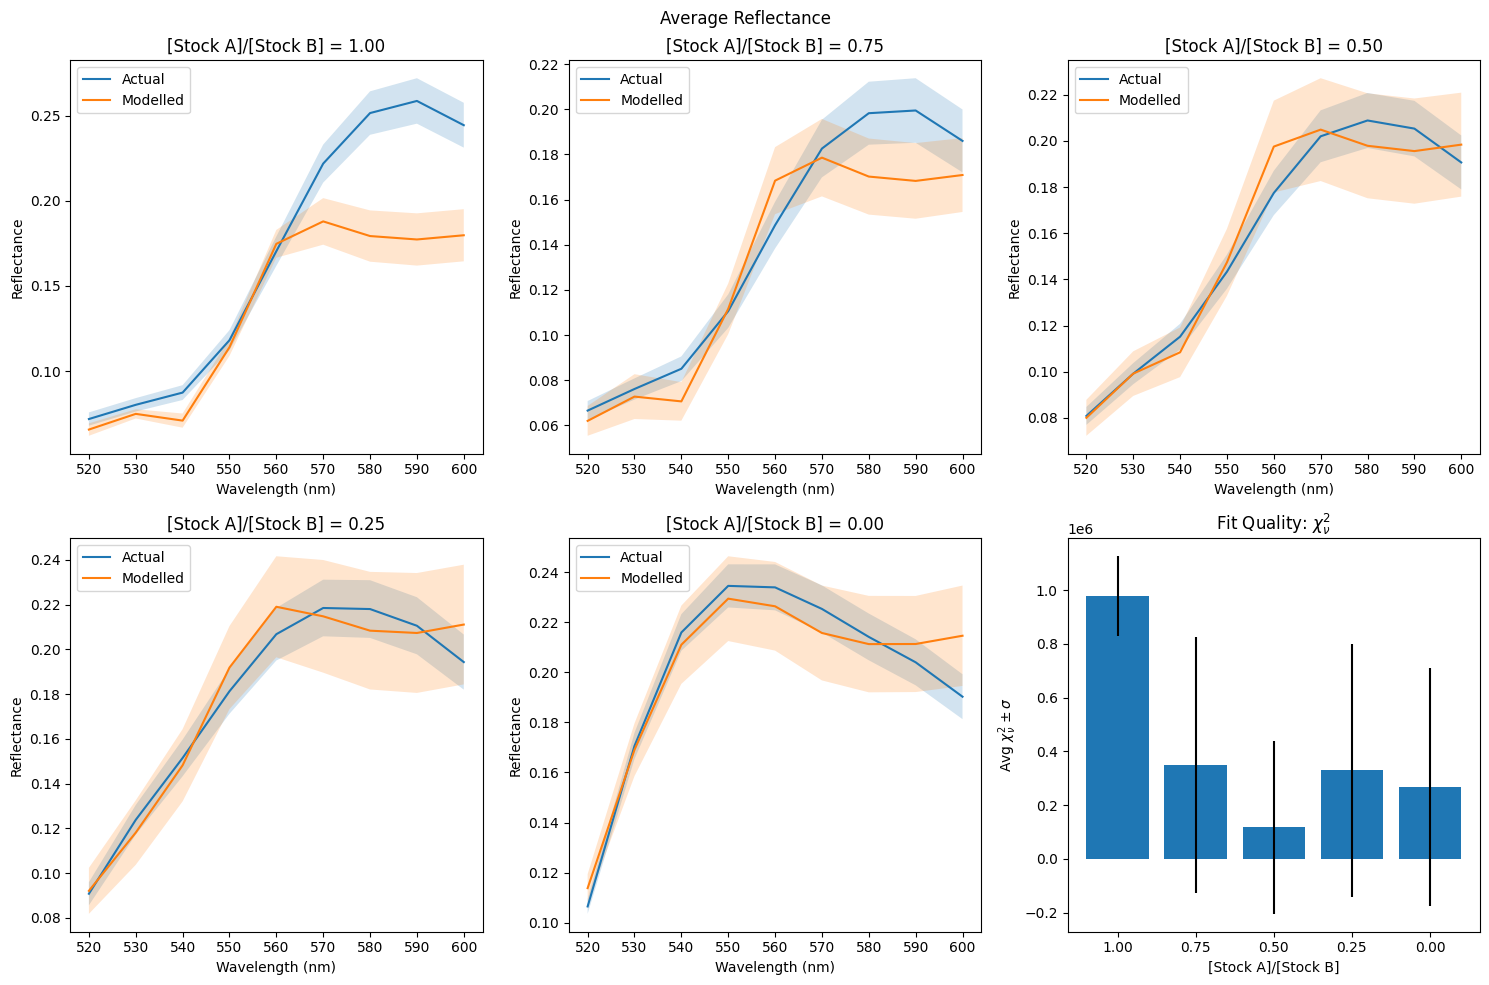

In [124]:
results = np.zeros((3, len(phantom_paths), 3))  # parameter, phantom, [mean, stdev, actual]
X2 = []
X2_std = []
CF = []
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Average Reflectance')
for idx, phantom in enumerate(tqdm(phantom_paths)):
    # Load the phantom
    conc_frac = f"{float(phantom.parts[-2].split('_')[1]) / 100:.2f}"
    CF.append(conc_frac)
    phantom_cube = HyperspectralImage(image_path=phantom, standard=standard_cube, background=background_cube, scalar=1, wavelengths=wavelengths)
    phantom_cube.normalize()
    phantom_cube.resize_to(32)

    # Fit it
    param_image, chi_sq = phantom_cube.fit(
        model=model_from_food_coloring,
        x0=[25, 1, 8, 0.5, 0],
        bounds=[(0, 0, 0, 0, -np.inf), (np.inf, np.inf, np.inf, 1, np.inf)],
        use_multiprocessing=False,
        pbar=True
    )
    a, b, t, s, c = param_image
    X2.append(np.nanmean(chi_sq))
    X2_std.append(np.nanstd(chi_sq))
    ax = axes.flat[idx]
    r_mean =  np.nanmean(phantom_cube, axis=(1, 2))
    r_std = 0.5 * np.nanstd(phantom_cube, axis=(1, 2))
    ax.plot(wavelengths, r_mean, label=f'Actual')
    ax.fill_between(wavelengths, r_mean - r_std, r_mean + r_std, alpha=0.2)

    R = np.zeros((len(wavelengths), *param_image.shape[1:]))
    for i, j in itertools.product(range(32), range(32)):
        R[:, i, j] = model_from_food_coloring(*param_image[:, i, j])
    r_mean = np.nanmean(R, axis=(1, 2))
    r_std = np.nanstd(R, axis=(1, 2))
    ax.plot(wavelengths, r_mean, label=f"Modelled")
    ax.set(xlabel='Wavelength (nm)', ylabel='Reflectance', title=f"[Stock A]/[Stock B] = {conc_frac}")
    ax.fill_between(wavelengths, r_mean - r_std, r_mean + r_std, alpha=0.2)
    ax.legend()

    if 'phantom' in phantom.parts[-2]:
        results[0, idx, :] = [np.nanmean(t), np.nanstd(t), 10]
        results[1, idx, :] = [np.nanmean(s), np.nanstd(s), float(phantom.parts[-2].split('_')[1]) / 100]
        results[2, idx, :] = [np.nanmean(c), np.nanstd(c), 0]

axes[1,2].bar(CF, X2, yerr=X2_std, width=0.8)
axes[1,2].set(xlabel="[Stock A]/[Stock B]", ylabel=r"Avg $\chi^2_\nu \pm \sigma$", title=r"Fit Quality: $\chi^2_\nu$")
plt.tight_layout()
plt.show()

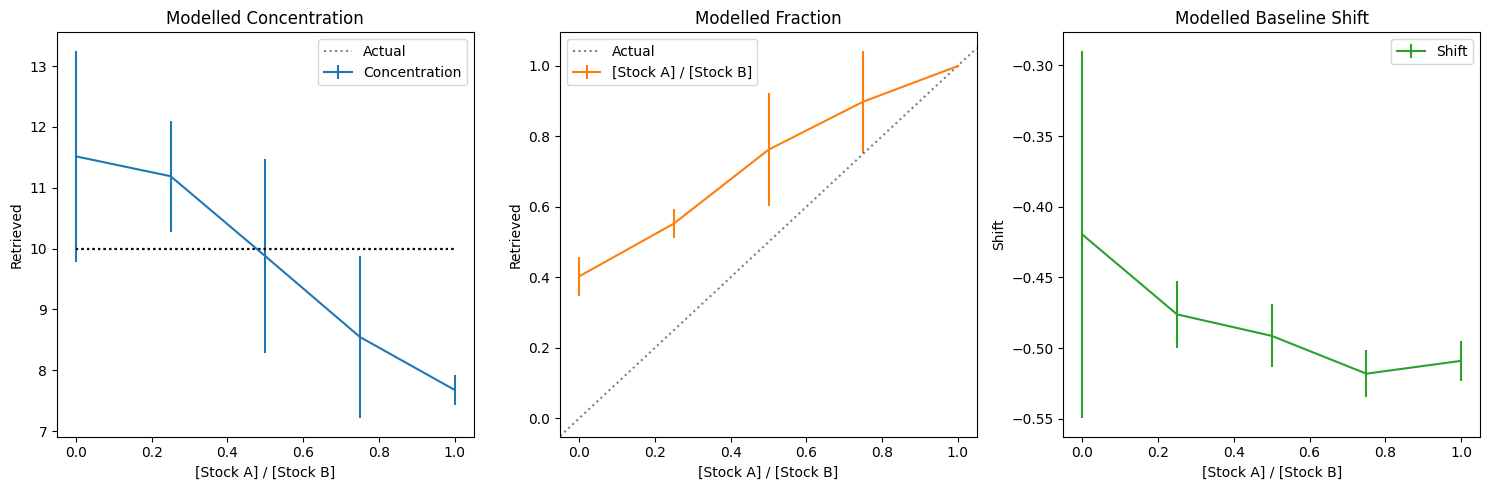

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].errorbar(results[1, :, 2], results[0, :, 0], yerr=results[0, :, 1], label="Concentration", color="C0")
ax[0].hlines(results[0, :, 2], 0, 1, color="k", ls=":", alpha=0.5, label="Actual")
ax[0].set(xlabel="[Stock A] / [Stock B]", ylabel="Retrieved", title="Modelled Concentration")
ax[0].legend()

ax[1].errorbar(results[1, :, 2], results[1, :, 0], yerr=results[1, :, 1], label="[Stock A] / [Stock B]", color="C1")
ax[1].axline((0, 0), (1, 1), label="Actual", color="k", ls=":", alpha=0.5)
ax[1].set(xlabel="[Stock A] / [Stock B]", ylabel="Retrieved", title="Modelled Fraction")
ax[1].legend()

ax[2].errorbar(results[1, :, 2], results[2, :, 0], yerr=results[2, :, 1], label="Shift", color="C2")
ax[2].set(xlabel="[Stock A] / [Stock B]", ylabel="Shift", title="Modelled Baseline Shift")
ax[2].legend()

plt.tight_layout()
plt.show()